In [1]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib
import mplfinance as mpf
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from datetime import datetime, timedelta
import math
import pickle
import gzip
%matplotlib inline

# Test PyTorch installation
import torch 
import torch.nn as nn
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler

In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
ticker = 'AAPL'
startDate = '2019-11-20'
endDate = '2020-8-25'

df = yf.Ticker(ticker).history(start=startDate, end=endDate)
del df['Dividends']
del df['Stock Splits']  

open_prices = df.loc[:,'Open'].values
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
close_prices = df.loc[:,'Close'].values
volume_daily = df.loc[:,'Volume'].values

def getTrainSplit(data, splitIndex):
    return data[:splitIndex], data[splitIndex:]

split = int(len(open_prices) * 0.7)

open_prices_train, open_prices_test = getTrainSplit(open_prices,split)
high_prices_train, high_prices_test = getTrainSplit(high_prices,split)
low_prices_train, low_prices_test = getTrainSplit(low_prices,split)
close_prices_train, close_prices_test = getTrainSplit(close_prices,split)
volume_daily_train, volume_daily_test = getTrainSplit(volume_daily,split)

OHLCV_train = []
OHLCV_test = []

scaler = MinMaxScaler(feature_range=(-1,1))
high_norm_train = scaler.fit_transform(high_prices_train.reshape(-1,1))
low_norm_train = scaler.fit_transform(low_prices_train.reshape(-1,1))
open_norm_train = scaler.fit_transform(open_prices_train.reshape(-1,1))
close_norm_train = scaler.fit_transform(close_prices_train.reshape(-1,1))
volume_norm_train = scaler.fit_transform(volume_daily_train.reshape(-1,1))

for i in range(len(open_prices_train)):
#     temp_train = [open_prices_train[i],high_prices_train[i],low_prices_train[i],close_prices_train[i],volume_daily_train[i]]
    temp_train = [open_norm_train[i],high_norm_train[i],low_norm_train[i],close_norm_train[i],volume_norm_train[i]]
    OHLCV_train.append(temp_train)

for i in range(len(open_prices_test)):
#     temp_test = [open_prices_test[i],high_prices_test[i],low_prices_test[i],close_prices_test[i],volume_daily_test[i]]
    temp_test = [open_prices_test[i],high_prices_test[i],low_prices_test[i],close_prices_test[i]]
    OHLCV_test.append(temp_test)

In [4]:
print(OHLCV_train[0])

[array([-0.2559475]), array([-0.25592805]), array([-0.14767314]), array([-0.25730071]), array([-0.57787193])]


In [5]:
train_data = torch.FloatTensor(OHLCV_train)

In [6]:
train_window = 21 # three weeks

def create_inout_sequences(input_data, tw):
    inout_seq = []
    label_size = 1 # 7 Days
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+label_size]
#         inout_seq.append((train_seq ,train_label))
        inout_seq.append((train_seq ,train_label[0][0]))
    return inout_seq
train_inout_seq = create_inout_sequences(train_data, train_window)

In [7]:
train_inout_seq[0][-1]

tensor([0.0812])

In [8]:
# # def batch(input_data, seq_length):
# # #     print(len(input_data))
# # #     print(seq_length)
# #     bSize = int(len(input_data)/seq_length)
# #     batches = []
# #     for i in range(1,bSize+1):
# #         start = (i-1)*seq_length
# #         end = i*seq_length-1
# #         batches.append(input_data[start:end])
# #     return batches


# # Number of features used as input. (Number of columns)
# INPUT_SIZE = 2 # [Open, High, Low, Close, Volume]

# # Number of previous time stamps taken into account.
# SEQ_LENGTH = 19 #

# # Number of features in last hidden state ie. number of output time-
# # steps to predict.See image below for more clarity.
# HIDDEN_SIZE = 4

# # Number of stacked rnn layers.
# NUM_LAYERS = 1

# # We have total of 20 rows in our input. 
# # We divide the input into 4 batches where each batch has only 1
# # row. Each row corresponds to a sequence of length 5. 
# BATCH_SIZE = 7

# # train_data_batches = batch(train_data, SEQ_LENGTH)

In [9]:
# print(len(OHLCV_train))

In [10]:
# # Initialize the RNN.
# rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers = NUM_LAYERS, batch_first=True)

# # input size : (batch, seq_len, input_size)
# inputs = train_data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)

# # out shape = (batch, seq_len, num_directions * hidden_size)
# # h_n shape  = (num_layers * num_directions, batch, hidden_size)
# out, h_n = rnn(inputs)

# print(inputs.shape)
# print(out.shape)
# print(h_n.shape)

In [11]:
# print(inputs[0])
# print(out[0])

In [12]:
class LSTM(nn.Module):
    ''' input_size: [open, high, low, close, volume] = 5
        hidden_layer_size: # of hidden layers along w number of neurons in each layer
        output_size: number of items in output (price at day)
    '''
    def __init__(self, input_size=5, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [13]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
epochs = 150
loss_arr = []

predictions = {}

for i in range(epochs):
    predTemp = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        predTemp.append(y_pred)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    loss_arr.append(single_loss.item())
    if i%25 == 1:
        predictions[i] = np.array(predTemp).reshape(-1,1)
#         print(predictions[i])
#         predictions[i] = scaler.inverse_transform(np.array(predTemp).reshape(-1, 1))
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00630204
epoch:  26 loss: 0.00012840
epoch:  51 loss: 0.00065171
epoch:  76 loss: 0.00121492
epoch: 101 loss: 0.00264932
epoch: 126 loss: 0.00107906
epoch: 149 loss: 0.0048339665


In [83]:
# print(predictions[1])

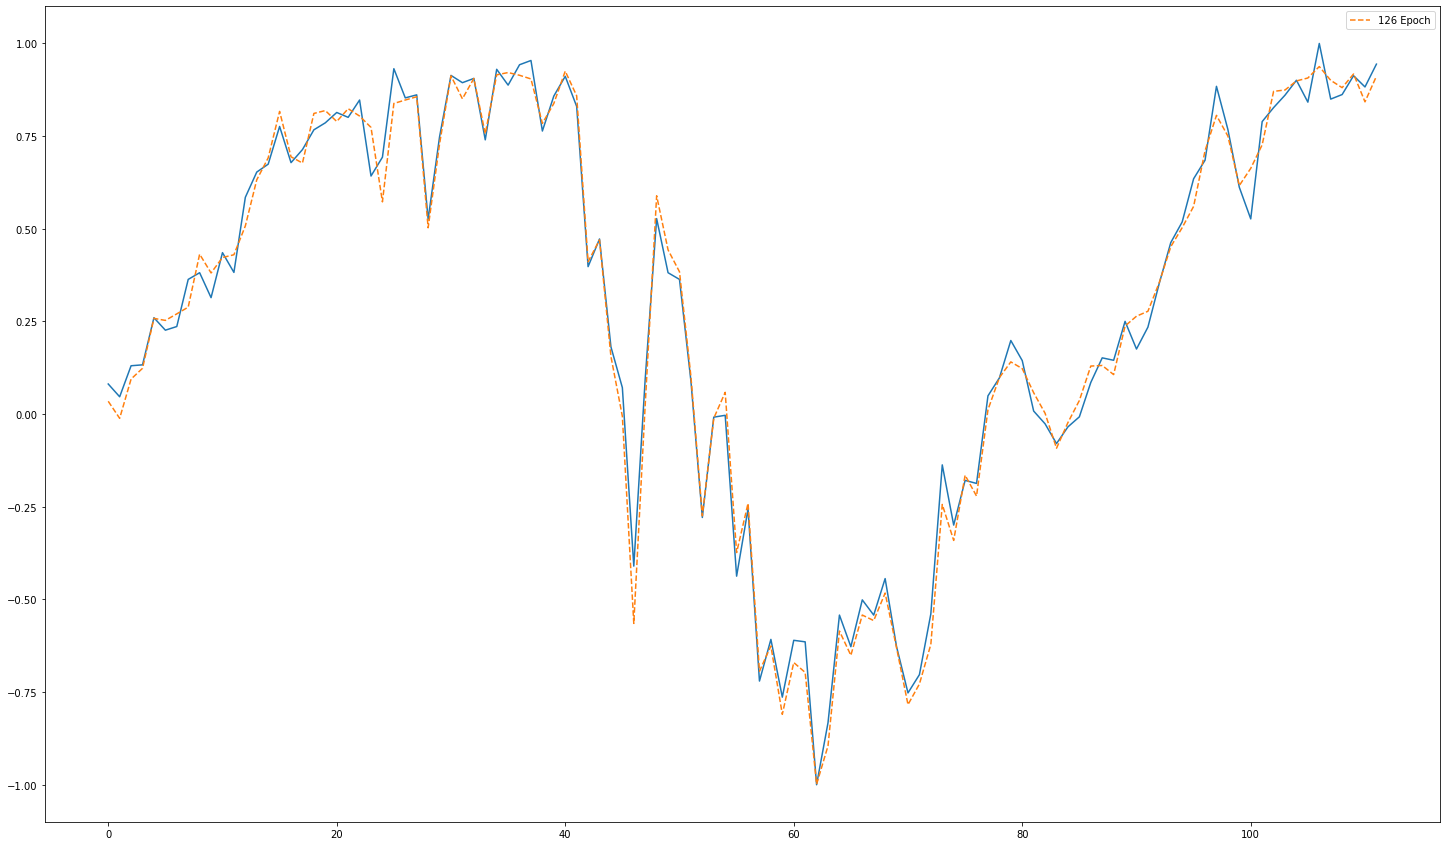

In [108]:
fig, ax = plt.subplots(figsize=[25,15])

# ax.plot(open_prices_train[train_window:split])
ax.plot(open_norm_train[train_window:split])

# ax.plot(train_data[:,0][train_window:split])

# ax.plot(mid_prices[train_window:split])
    
# ax.plot(predictions[1], label = "1 Epoch", ls="--")
# ax.plot(predictions[26], label = "26 Epoch", ls="--")
# ax.plot(predictions[51], label = "51 Epoch", ls="--")
# ax.plot(predictions[76], label = "76 Epoch", ls="--")
# ax.plot(predictions[101], label = "101 Epoch", ls="--")
ax.plot(predictions[126], label = "126 Epoch", ls="--")

ax.legend()

plt.show()

In [157]:
fut_pred = 7

test_inputs = train_inout_seq[-train_window:]

model.eval()

for i in range(fut_pred):
    seq = test_inputs[-train_window:]
#     seq = torch.FloatTensor(test_inputs[-train_window:])
#     seq = torch.from_numpy(np.array(test_inputs[-train_window:])).type(torch.Tensor)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
#         print(model(seq))
        test_inputs.append([model(seq),test_inputs[-1][1],test_inputs[-1][2],test_inputs[-1][3],test_inputs[-1][4]])

AttributeError: 'list' object has no attribute 'view'